# Network Comparison Experiments

This notebook compares training results across different seeds and network topologies.

- Seed comparison: Train 5 networks with seeds 0-4
- Topology comparison: Vary hidden layers (1-7) and neurons (1-8) with seed=0
- Both experiments share cached checkpoints where topologies and seeds overlap

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt

from lib import (
    Net, NetConfig,
    SymbolicActivation, SymbolicLoss, WeightInit,
    CheckpointConfig, compute_data_hash
)

In [2]:
# Generate training data
np.random.seed(42)

q1 = np.random.uniform(-1, 1, 1000)
q2 = np.random.uniform(-1, 1, 1000)

def target_function(q1, q2):
    X1 = q1 + q2
    X2 = q1 - q2
    return X1, X2

X1, X2 = target_function(q1, q2)

inputs = [[q1[i], q2[i]] for i in range(len(q1))]
targets = [[X1[i], X2[i]] for i in range(len(X1))]

inputs = np.array(inputs)
targets = np.array(targets)

input_list = [inputs[i] for i in range(len(inputs))]
target_list = [targets[i] for i in range(len(targets))]

print(f"Generated {len(inputs)} training samples")
print(f"Input shape: {inputs.shape}")
print(f"Target shape: {targets.shape}")

Generated 1000 training samples
Input shape: (1000, 2)
Target shape: (1000, 2)


In [3]:
# Compute hash for training data (enables checkpoint sharing)
data_hash = compute_data_hash(input_list, target_list)
print(f"Data hash: {data_hash}")

# Configure checkpointing
checkpoint_config = CheckpointConfig(
    enabled=True,
    cache_dir='.net_cache',
    checkpoint_interval=20,
    data_hash=data_hash,
    overwrite=False
)
print("Checkpointing enabled")

Data hash: c45174a065888bc7
Checkpointing enabled


## Seed Comparison

Train 5 networks with seeds 0 to 4 to see effect of random initialization.

In [4]:
seed_results = {}
seeds = range(5)
epochs = 3000
learning_rate = 0.01

for seed in seeds:
    print(f"Training with seed={seed}...")
    
    config = NetConfig(hidden_activation=SymbolicActivation.linear(), output_activation=SymbolicActivation.linear(), 
        n_inputs=2,
        n_outputs=2,
        n_hidden_layers=2,
        n_neurons_per_hidden=4,
        loss_func=SymbolicLoss.mse(),
        weight_init=WeightInit.XAVIER,
        bias_init_std=0.01,
        seed=seed
    )
    
    net = Net.fully_connected(config)
    
    result = net.train(
        inputs=input_list,
        targets=target_list,
        learning_rate=learning_rate,
        epochs=epochs,
        batch_size=32,
        checkpoint_config=checkpoint_config
    )
    
    seed_results[seed] = result['loss_history']
    print(f"  Seed {seed}: final loss = {result['loss_history'][-1]:.6f}")

print("\nAll seed experiments complete!")

Training with seed=0...
Saved checkpoint at epoch 20
Saved checkpoint at epoch 40
Saved checkpoint at epoch 60
Saved checkpoint at epoch 80
Saved checkpoint at epoch 100
Saved checkpoint at epoch 120
Saved checkpoint at epoch 140
Saved checkpoint at epoch 160
Saved checkpoint at epoch 180
Saved checkpoint at epoch 200
Saved checkpoint at epoch 220
Saved checkpoint at epoch 240
Saved checkpoint at epoch 260
Saved checkpoint at epoch 280
Saved checkpoint at epoch 300
Saved checkpoint at epoch 320
Saved checkpoint at epoch 340
Saved checkpoint at epoch 360
Saved checkpoint at epoch 380
Saved checkpoint at epoch 400
Saved checkpoint at epoch 420
Saved checkpoint at epoch 440
Saved checkpoint at epoch 460
Saved checkpoint at epoch 480
Saved checkpoint at epoch 500
Saved checkpoint at epoch 520
Saved checkpoint at epoch 540
Saved checkpoint at epoch 560
Saved checkpoint at epoch 580
Saved checkpoint at epoch 600
Saved checkpoint at epoch 620
Saved checkpoint at epoch 640
Saved checkpoint at 

### Seed Comparison Plot

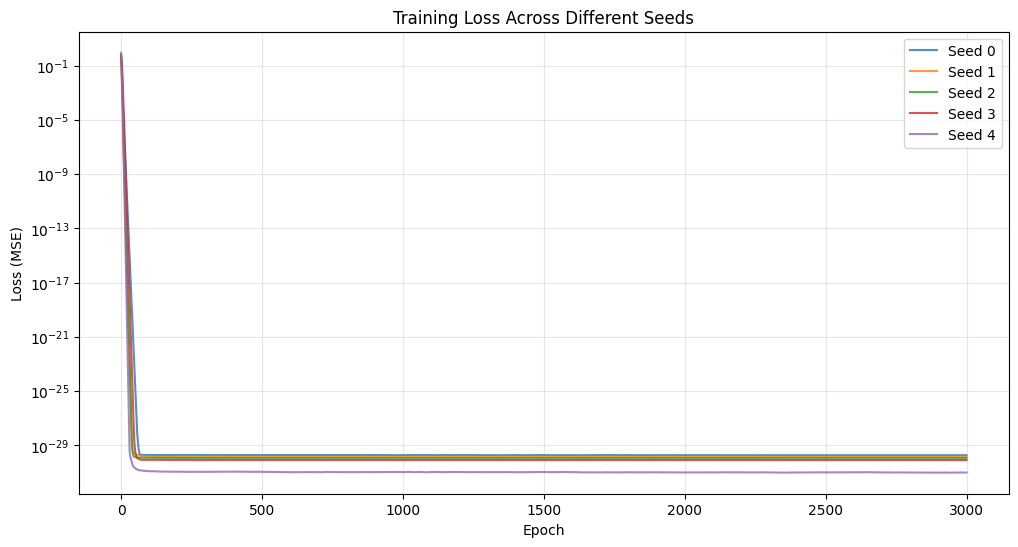

Final losses: ['0.000000', '0.000000', '0.000000', '0.000000', '0.000000']
Mean final loss: 0.000000
Std final loss: 0.000000
Min final loss: 0.000000 (seed 4)
Max final loss: 0.000000 (seed 0)


In [5]:
plt.figure(figsize=(12, 6))

for seed, loss_history in seed_results.items():
    plt.plot(loss_history, label=f'Seed {seed}', alpha=0.8)

plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss Across Different Seeds')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

# Statistics
final_losses = [seed_results[s][-1] for s in seeds]
print(f"Final losses: {[f'{l:.6f}' for l in final_losses]}")
print(f"Mean final loss: {np.mean(final_losses):.6f}")
print(f"Std final loss: {np.std(final_losses):.6f}")
print(f"Min final loss: {np.min(final_losses):.6f} (seed {seeds[np.argmin(final_losses)]})")
print(f"Max final loss: {np.max(final_losses):.6f} (seed {seeds[np.argmax(final_losses)]})")

## Topology Comparison

Compare training loss for different network topologies with seed=0.

- Hidden layers: 1 to 7
- Neurons per hidden layer: 1 to 8

**Note:** The topology with 2 hidden layers and 4 neurons per layer will reuse the cached checkpoint from the seed comparison experiment (seed=0).

In [6]:
topology_results = {}
hidden_layers_range = range(1, 9)
neurons_range = range(1, 9)
epochs = 3000
learning_rate = 0.01
seed = 0

for n_hidden in hidden_layers_range:
    for n_neurons in neurons_range:
        print(f"Training: {n_hidden} hidden layers, {n_neurons} neurons each...")
        
        config = NetConfig(hidden_activation=SymbolicActivation.linear(), output_activation=SymbolicActivation.linear(), 
            n_inputs=2,
            n_outputs=2,
            n_hidden_layers=n_hidden,
            n_neurons_per_hidden=n_neurons,
            loss_func=SymbolicLoss.mse(),
            weight_init=WeightInit.XAVIER,
            bias_init_std=0.01,
            seed=seed
        )
        
        net = Net.fully_connected(config)
        
        result = net.train(
            inputs=input_list,
            targets=target_list,
            learning_rate=learning_rate,
            epochs=epochs,
            batch_size=32,
            checkpoint_config=checkpoint_config
        )
        
        topology_results[(n_hidden, n_neurons)] = result['loss_history']
        print(f"  Final loss: {result['loss_history'][-1]:.6f}")

print("\nAll topology experiments complete!")

Training: 1 hidden layers, 1 neurons each...
Saved checkpoint at epoch 20
Saved checkpoint at epoch 40
Saved checkpoint at epoch 60
Saved checkpoint at epoch 80
Saved checkpoint at epoch 100
Saved checkpoint at epoch 120
Saved checkpoint at epoch 140
Saved checkpoint at epoch 160
Saved checkpoint at epoch 180
Saved checkpoint at epoch 200
Saved checkpoint at epoch 220
Saved checkpoint at epoch 240
Saved checkpoint at epoch 260
Saved checkpoint at epoch 280
Saved checkpoint at epoch 300
Saved checkpoint at epoch 320
Saved checkpoint at epoch 340
Saved checkpoint at epoch 360
Saved checkpoint at epoch 380
Saved checkpoint at epoch 400
Saved checkpoint at epoch 420
Saved checkpoint at epoch 440
Saved checkpoint at epoch 460
Saved checkpoint at epoch 480
Saved checkpoint at epoch 500
Saved checkpoint at epoch 520
Saved checkpoint at epoch 540
Saved checkpoint at epoch 560
Saved checkpoint at epoch 580
Saved checkpoint at epoch 600
Saved checkpoint at epoch 620
Saved checkpoint at epoch 640

### Final Loss Heatmap

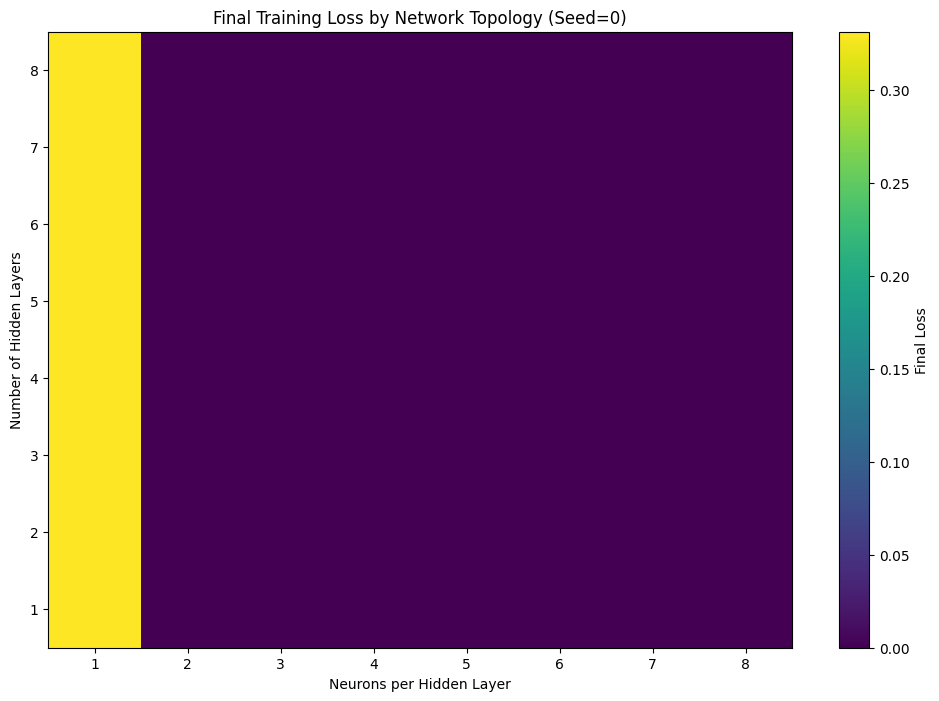

Best topology: 4 hidden layers, 8 neurons each
Best final loss: 0.000000
Total parameters: 202


In [7]:
# Create heatmap of final losses
final_loss_grid = np.zeros((len(hidden_layers_range), len(neurons_range)))

for i, n_hidden in enumerate(hidden_layers_range):
    for j, n_neurons in enumerate(neurons_range):
        final_loss_grid[i, j] = topology_results[(n_hidden, n_neurons)][-1]

plt.figure(figsize=(12, 8))
im = plt.imshow(final_loss_grid, cmap='viridis', aspect='auto', origin='lower')

plt.xticks(range(len(neurons_range)), neurons_range)
plt.yticks(range(len(hidden_layers_range)), hidden_layers_range)
plt.xlabel('Neurons per Hidden Layer')
plt.ylabel('Number of Hidden Layers')
plt.title('Final Training Loss by Network Topology (Seed=0)')
plt.colorbar(im, label='Final Loss')
plt.show()

# Find best topology
best_idx = np.unravel_index(np.argmin(final_loss_grid), final_loss_grid.shape)
best_n_hidden = hidden_layers_range[best_idx[0]]
best_n_neurons = neurons_range[best_idx[1]]
best_loss = final_loss_grid[best_idx]

print(f"Best topology: {best_n_hidden} hidden layers, {best_n_neurons} neurons each")
print(f"Best final loss: {best_loss:.6f}")
print(f"Total parameters: {best_n_hidden * best_n_neurons * (2 + best_n_hidden) + 2 * best_n_hidden + 2}")

### Training Curves by Topology

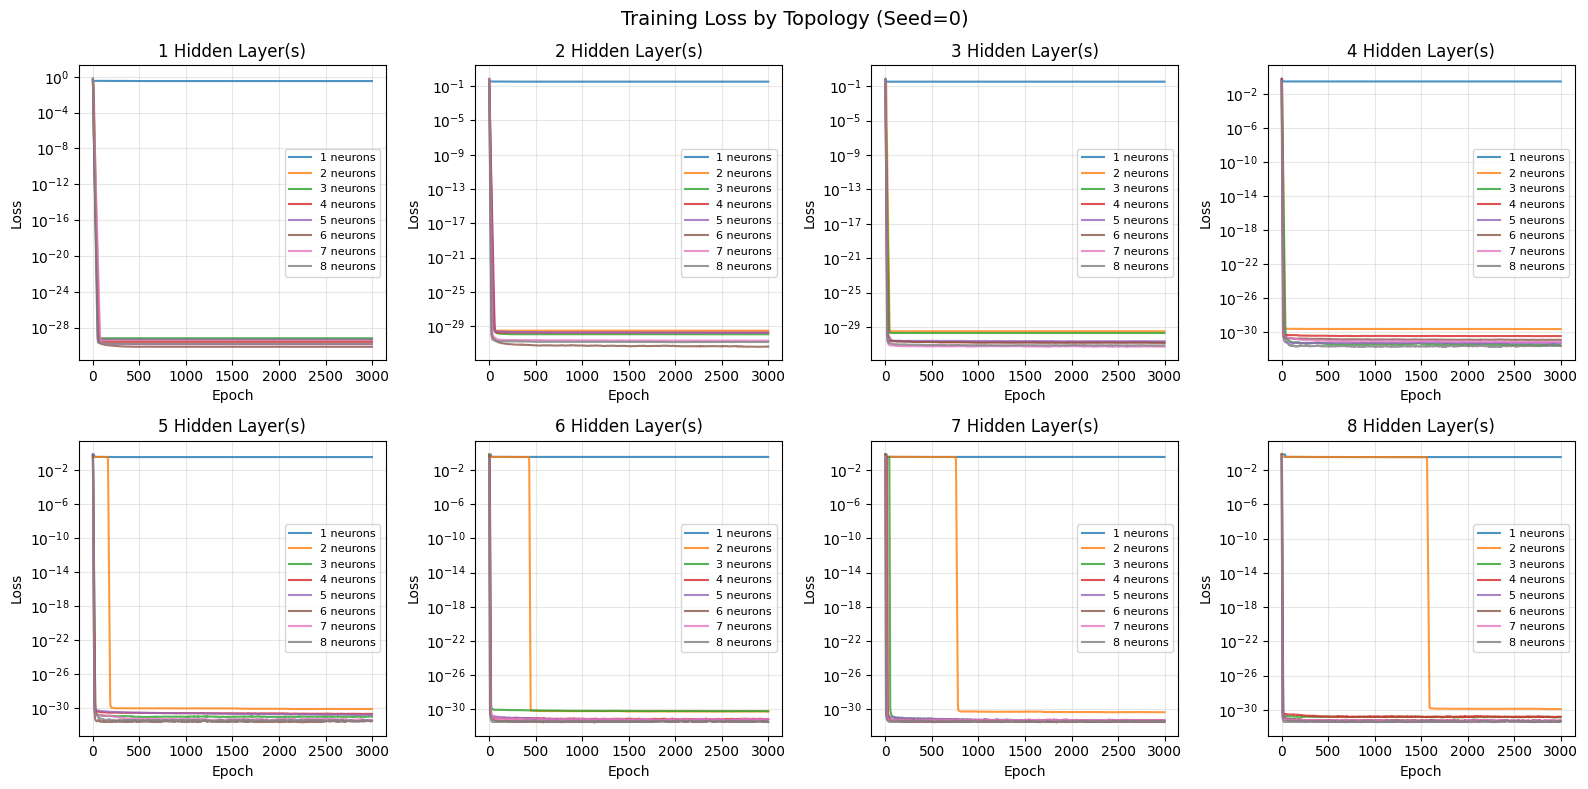

In [8]:
# Plot a few representative topologies
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Training Loss by Topology (Seed=0)', fontsize=14)

for idx, n_hidden in enumerate(hidden_layers_range):
    row = idx // 4
    col = idx % 4
    ax = axes[row, col]
    
    for n_neurons in neurons_range:
        if (n_hidden, n_neurons) in topology_results:
            loss_hist = topology_results[(n_hidden, n_neurons)]
            ax.plot(loss_hist, label=f'{n_neurons} neurons', alpha=0.8)
    
    ax.set_title(f'{n_hidden} Hidden Layer(s)')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

plt.tight_layout()
plt.show()

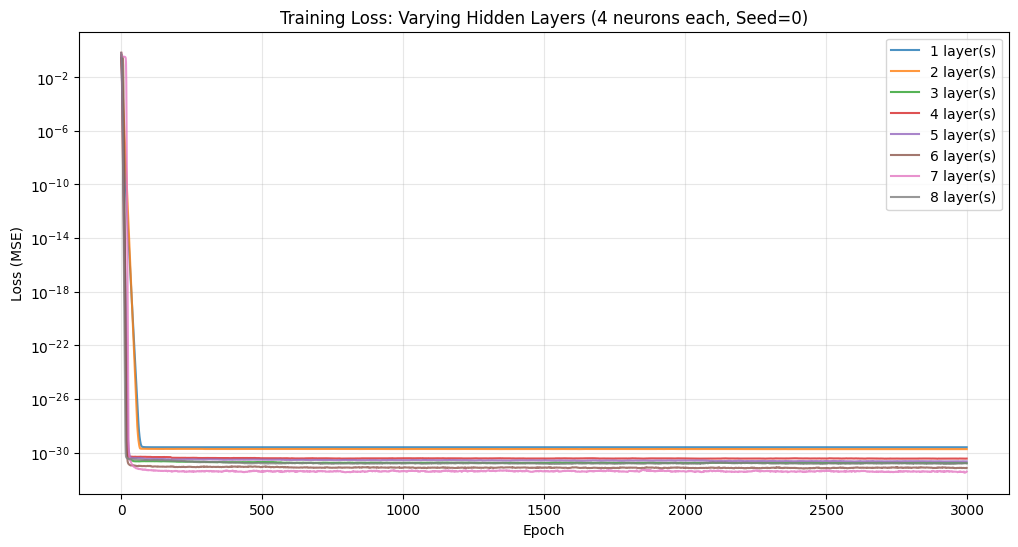

In [9]:
# Plot all topologies with fixed neurons (4)
plt.figure(figsize=(12, 6))

for n_hidden in hidden_layers_range:
    n_neurons = 4
    loss_hist = topology_results[(n_hidden, n_neurons)]
    plt.plot(loss_hist, label=f'{n_hidden} layer(s)', alpha=0.8)

plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss: Varying Hidden Layers (4 neurons each, Seed=0)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

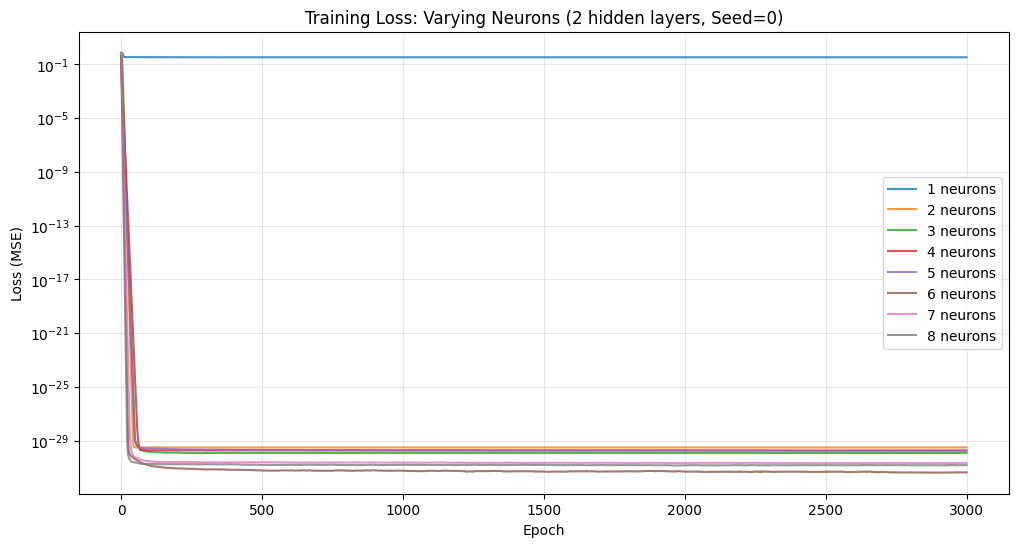

In [10]:
# Plot all topologies with fixed layers (2)
plt.figure(figsize=(12, 6))

for n_neurons in neurons_range:
    n_hidden = 2
    loss_hist = topology_results[(n_hidden, n_neurons)]
    plt.plot(loss_hist, label=f'{n_neurons} neurons', alpha=0.8)

plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss: Varying Neurons (2 hidden layers, Seed=0)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

## Summary

### Key Findings:

In [11]:
# Compute summary statistics
print("=" * 60)
print("SEED COMPARISON SUMMARY")
print("=" * 60)
seed_final = [seed_results[s][-1] for s in seeds]
print(f"Seeds tested: {list(seeds)}")
print(f"Final losses: {[f'{l:.6f}' for l in seed_final]}")
print(f"Mean: {np.mean(seed_final):.6f}")
print(f"Std: {np.std(seed_final):.6f}")
print(f"Range: [{np.min(seed_final):.6f}, {np.max(seed_final):.6f}]")

print("\n" + "=" * 60)
print("TOPOLOGY COMPARISON SUMMARY")
print("=" * 60)
print(f"Hidden layers tested: {list(hidden_layers_range)}")
print(f"Neurons tested: {list(neurons_range)}")
print(f"Total configurations: {len(hidden_layers_range) * len(neurons_range)}")

all_final_losses = [topology_results[(h, n)][-1] for h in hidden_layers_range for n in neurons_range]
print(f"\nBest final loss: {np.min(all_final_losses):.6f}")
print(f"Worst final loss: {np.max(all_final_losses):.6f}")
print(f"Mean final loss: {np.mean(all_final_losses):.6f}")
print(f"Median final loss: {np.median(all_final_losses):.6f}")

SEED COMPARISON SUMMARY
Seeds tested: [0, 1, 2, 3, 4]
Final losses: ['0.000000', '0.000000', '0.000000', '0.000000', '0.000000']
Mean: 0.000000
Std: 0.000000
Range: [0.000000, 0.000000]

TOPOLOGY COMPARISON SUMMARY
Hidden layers tested: [1, 2, 3, 4, 5, 6, 7, 8]
Neurons tested: [1, 2, 3, 4, 5, 6, 7, 8]
Total configurations: 64

Best final loss: 0.000000
Worst final loss: 0.331480
Mean final loss: 0.041432
Median final loss: 0.000000
